## Configuração de API

In [1]:
CLIENT_ID = "SEUID"
SECRET_KEY = "SUASENHA"

In [1]:
import requests
import pandas as pd

In [3]:
auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_KEY)

In [4]:
with open('pw.txt', 'r') as f:
    pw = f.read()

In [5]:
data = {
    'grant_type': 'password',
    'username': 'SEUUSER',
    'password': pw
}

In [6]:
headers = {'User-Agent': 'MyAPI/0.01'}

In [7]:
res = requests.post('https://www.reddit.com/api/v1/access_token', 
                   auth=auth, data=data, headers=headers)

In [8]:
TOKEN = res.json()['access_token']

In [9]:
headers = {**headers, **{'Authorization': f'bearer {TOKEN}'}}

In [10]:
# headers

In [11]:
# requests.get('https://oauth.reddit.com/api/v1/me', headers={'User-Agent': 'MyAPI/0.01'})

In [12]:
# requests.get('https://oauth.reddit.com/api/v1/me', headers=headers).json()

In [13]:
res = requests.get('https://oauth.reddit.com/r/popheads//hot',
                headers=headers, params={'limit': '100'})

In [14]:
all_posts_data = []

for post in res.json()['data']['children']:
    post_data_dict = {
        'id_post': post['data'].get('id'),
        'title': post['data'].get('title'),
        'author': post['data'].get('author'),
        'subreddit': post['data'].get('subreddit'),
        'ups': post['data'].get('ups'),
        'upvote_ratio': post['data'].get('upvote_ratio'),
        'downs': post['data'].get('downs'),
        'score': post['data'].get('score'),
        'num_comments': post['data'].get('num_comments'),
        'is_self': post['data'].get('is_self'), 
        'selftext': post['data'].get('selftext', ''),
        'created_utc': post['data'].get('created_utc')
    }
    all_posts_data.append(post_data_dict)

df = pd.DataFrame(all_posts_data)

## Descrição da Base de Dados e Atributos Coletados

### Atributos Originais

Para esta atividade, foram coletados os dados sobre os posts do subreddit "popheads". A coleta foi feita através da API do Reddit, resultando em um conjunto de 102 postagens. 
Esta base de dados, ainda em seu formato bruto, contém as seguintes informações para cada postagem:
- id_post: ID do post;
- title: Título do post;
- author: Autor do post;
- subreddit: Subreddit referente ao post;
- ups: Número de "upvotes" que o post recebeu;
- upvote_ratio: Proporção de "upvotes" em relação ao total de votos ("upvotes" + "downvotes");
- downs: Número de "downvotes" que o post recebeu;
- score: Pontuação do post calculada como "ups" - "downs";
- num_commets: Número de comentários do post;
- is_self: : Indica se o post é um post de texto (True) ou post de um link externo (False);
- selftext: Contém o corpo do texto do post (caso seja um post de texto);
- created_ufc: Timestamp Unix da criação do post

### Atributos Derivados

Número de caracteres presentes no título da postagem. Essa informação pode ajudar a analisar se a concisão ou a extenão do título influenciam o engajamento ou o tipo de conteúdo.

In [15]:
df['len_title'] = df['title'].str.len()

Representação em formato de data e hora legível do timestamp Unix da criação da postagem. Essa informação é útil pois ajuda a extrair informações temporais mais granulares.

In [16]:
df['datetime'] = pd.to_datetime(df['created_utc'], unit='s', utc=True)

A hora do dia em que a postagem foi criada. Essa informação auxilia a identificar os horários de pico de atividade na comunidade.

In [17]:
df['post_hour'] = df['datetime'].dt.hour

O dia da semana (0 para segunda-feira a 6 para domingo) em que a postagem foi criada. Com essa informação, é possível analisar padrões de postagem e engajamento ao longo da semana.

In [18]:
df['post_day_of_week'] = df['datetime'].dt.dayofweek

Representa engajamento total da postagem, calculada como a soma de votos positivos e número de comentários. Isso oferece uma visão consolidada da popularidade e da capacidade de discussão que a postagem gerou.

In [82]:
df['engagement_score'] = df['ups'] + df['num_comments']

In [83]:
df.to_csv('df', index=False)

## Dataframe

In [84]:
import pandas as pd

In [87]:
df = pd.read_csv('df')

In [88]:
df.count()

id_post             102
title               102
author              102
subreddit           102
ups                 102
upvote_ratio        102
downs               102
score               102
num_comments        102
is_self             102
selftext             22
created_utc         102
len_title           102
datetime            102
post_hour           102
post_day_of_week    102
engagement_score    102
dtype: int64

## Pré-processamento

#### Normalização do título e do texto da postagem

In [6]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [89]:
import numpy as np
import nltk

In [90]:
df['title'] = df['title'].replace('nan', np.nan, regex=False)
df['selftext'] = df['selftext'].replace('nan', np.nan, regex=False)

df['title'] = df['title'].replace('', value = np.nan)
df['selftext'] = df['selftext'].replace('', value= np.nan)

df['title'] = df['title'].str.lower()
df['selftext'] = df['selftext'].str.lower()


df_text_processing = df[['id_post', 'title', 'selftext']].copy()

In [91]:
df_text_processing['selftext'] = df_text_processing['selftext'].fillna('')
df_text_processing['title'] = df_text_processing['title'].fillna('')

#### Conversão de emojis

In [92]:
!pip install emoji

Defaulting to user installation because normal site-packages is not writeable


In [93]:
import emoji 
import re 

In [94]:
def convert_unicode(text):
    return emoji.demojize(text, language='en', delimiters=(" ", " "))

df_text_processing['title'] = df_text_processing['title'].apply(convert_unicode)
df_text_processing['selftext'] = df_text_processing['selftext'].apply(convert_unicode)

emoticon_mapping = {
    r':\)\s*': ' _happy_face_ ',  # :)
    r':-\)\s*': ' _happy_face_ ', # :-)
    r'\(\s*:\)': ' _happy_face_ ', # (:
    r':D\s*': ' _big_smile_ ',   # :D
    r':\(\s*': ' _sad_face_ ',   # :(
    r':-\(\s*': ' _sad_face_ ',  # :-(
    r';\)\s*': ' _winking_face_ ', # ;)
    r':\/\s*': ' _confused_face_ ', # :/
    r':O\s*': ' _surprise_face_ ', # :O
    r'xD\s*': ' _laughing_face_ ', # xD
}

def convert_emoticons(text):
    for pattern, replacement in emoticon_mapping.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

df_text_processing['title'] = df_text_processing['title'].apply(convert_emoticons)
df_text_processing['selftext'] = df_text_processing['selftext'].apply(convert_emoticons)

#### Tokenização

In [95]:
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer

In [96]:
tokenizer = RegexpTokenizer(r'\w+')

df_text_processing['title_tokens'] = df_text_processing['title'].apply(tokenizer.tokenize)
df_text_processing['selftext_tokens'] = df_text_processing['selftext'].apply(tokenizer.tokenize)

#### Remoção de stop words

In [97]:
from nltk.corpus import stopwords

In [98]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

df_text_processing['title_stopwords'] = df_text_processing['title_tokens'].apply(remove_stopwords)
df_text_processing['selftext_stopwords'] = df_text_processing['selftext_tokens'].apply(remove_stopwords)

#### Lematização

In [99]:
from nltk.stem import WordNetLemmatizer

In [100]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens_cleaned(tokens):
    return [lemmatizer.lemmatize(word, pos='n') for word in tokens]

df_text_processing['title_lemmas'] = df_text_processing['title_stopwords'].apply(lemmatize_tokens_cleaned)
df_text_processing['selftext_lemmas'] = df_text_processing['selftext_stopwords'].apply(lemmatize_tokens_cleaned)

### Junção dos dataframes para obter a coluna engajament_score

In [101]:
df

,id_post,title,author,subreddit,ups,upvote_ratio,downs,score,num_comments,is_self,selftext,created_utc,len_title,datetime,post_hour,post_day_of_week,engagement_score
0,1lihdmp,"daily discussion - june 23, 2025",AutoModerator,popheads,8,0.83,0,8,252,True,"talk about anything, music related or not. how...",1.750687e+09,32,2025-06-23 14:01:44+00:00,14,0,260
1,1lixuol,"the popheads charts, june 23rd, 2025: a top te...",ImADudeDuh,popheads,27,0.97,0,27,8,True,[hot 50 spotify playlist](https://open.spotify...,1.750727e+09,71,2025-06-24 01:01:40+00:00,1,1,35
2,1lj1i2x,pitchfork review: benson boone - american hear...,buddhacharm,popheads,683,0.95,0,683,243,False,NaN,1.750738e+09,53,2025-06-24 04:07:02+00:00,4,1,926
3,1lip81p,"cardi b announces new album ""am i the drama?"",...",greatbarrierrif,popheads,990,0.95,0,990,256,False,NaN,1.750705e+09,69,2025-06-23 19:01:21+00:00,19,0,1246
4,1lj0y7x,benson boone - american heart (theneedledrop a...,xxipil0ts,popheads,144,0.81,0,144,75,False,NaN,1.750736e+09,58,2025-06-24 03:37:19+00:00,3,1,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1lgbnks,the knocks &amp; dragonette - friday night,Ghost-Quartet,popheads,46,0.99,0,46,5,False,NaN,1.750445e+09,42,2025-06-20 18:42:34+00:00,18,4,51
98,1lgeyf0,audrey hobert - bowling alley (official video),augggie,popheads,24,0.92,0,24,5,False,NaN,1.750453e+09,46,2025-06-20 21:00:53+00:00,21,4,29
99,1lfujc5,katseye - gabriela,mcfw31,popheads,567,0.94,0,567,71,False,NaN,1.750392e+09,18,2025-06-20 04:00:00+00:00,4,4,638
100,1lgcz4q,mura masa &amp; george riley - forever,VarjakVoid,popheads,28,0.98,0,28,5,False,NaN,1.750448e+09,38,2025-06-20 19:36:56+00:00,19,4,33


In [104]:
df_aux = df[['id_post', 'engagement_score']].copy()

In [119]:
df_text_processing = pd.merge(df_aux, df_text_processing, on='id_post', how='inner')

In [120]:
df_text_processing

,id_post,engagement_score,title,selftext,title_tokens,selftext_tokens,title_stopwords,selftext_stopwords,title_lemmas,selftext_lemmas
0,1lihdmp,260,"daily discussion - june 23, 2025","talk about anything, music related or not. how...","[daily, discussion, june, 23, 2025]","[talk, about, anything, music, related, or, no...","[daily, discussion, june, 23, 2025]","[talk, anything, music, related, however, pop,...","[daily, discussion, june, 23, 2025]","[talk, anything, music, related, however, pop,..."
1,1lixuol,35,"the popheads charts, june 23rd, 2025: a top te...",[hot 50 spotify playlist](https _confused_face...,"[the, popheads, charts, june, 23rd, 2025, a, t...","[hot, 50, spotify, playlist, https, _confused_...","[popheads, charts, june, 23rd, 2025, top, ten,...","[hot, 50, spotify, playlist, https, _confused_...","[popheads, chart, june, 23rd, 2025, top, ten, ...","[hot, 50, spotify, playlist, http, _confused_f..."
2,1lj1i2x,926,pitchfork review: benson boone - american hear...,,"[pitchfork, review, benson, boone, american, h...",[],"[pitchfork, review, benson, boone, american, h...",[],"[pitchfork, review, benson, boone, american, h...",[]
3,1lip81p,1246,"cardi b announces new album ""am i the drama?"",...",,"[cardi, b, announces, new, album, am, i, the, ...",[],"[cardi, b, announces, new, album, drama, septe...",[],"[cardi, b, announces, new, album, drama, septe...",[]
4,1lj0y7x,219,benson boone - american heart (theneedledrop a...,,"[benson, boone, american, heart, theneedledrop...",[],"[benson, boone, american, heart, theneedledrop...",[],"[benson, boone, american, heart, theneedledrop...",[]
...,...,...,...,...,...,...,...,...,...,...
97,1lgbnks,51,the knocks &amp; dragonette - friday night,,"[the, knocks, amp, dragonette, friday, night]",[],"[knocks, amp, dragonette, friday, night]",[],"[knock, amp, dragonette, friday, night]",[]
98,1lgeyf0,29,audrey hobert - bowling alley (official video),,"[audrey, hobert, bowling, alley, official, video]",[],"[audrey, hobert, bowling, alley, official, video]",[],"[audrey, hobert, bowling, alley, official, video]",[]
99,1lfujc5,638,katseye - gabriela,,"[katseye, gabriela]",[],"[katseye, gabriela]",[],"[katseye, gabriela]",[]
100,1lgcz4q,33,mura masa &amp; george riley - forever,,"[mura, masa, amp, george, riley, forever]",[],"[mura, masa, amp, george, riley, forever]",[],"[mura, masa, amp, george, riley, forever]",[]


### TF-IDF

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [122]:
df_text_processing['combined_lemmas'] = df_text_processing.apply(
    lambda row: row['title_lemmas'] + row['selftext_lemmas'], axis=1
)

df_text_processing['text_for_tfidf'] = df_text_processing['combined_lemmas'].apply(lambda tokens: ' '.join(tokens))

#### Removendo números após a junção dos textos

In [123]:
def remove(text):
    if pd.isna(text):
        return text
    result = re.sub(r'\d+', '', str(text)) 
    return result.strip()

df_text_processing['text_for_tfidf'] = df_text_processing['text_for_tfidf'].apply(remove)

#### Aplicação do algoritmo

In [124]:
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df_text_processing['text_for_tfidf'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [125]:
c = tfidf_df.columns[ (tfidf_df > 0).any() ].tolist()

#### Tópicos mais comuns 

In [126]:
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt1

import seaborn as sns

/tmp/ipykernel_8355/2939860132.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words_for_plot.values, y=top_words_for_plot.index, palette='viridis')


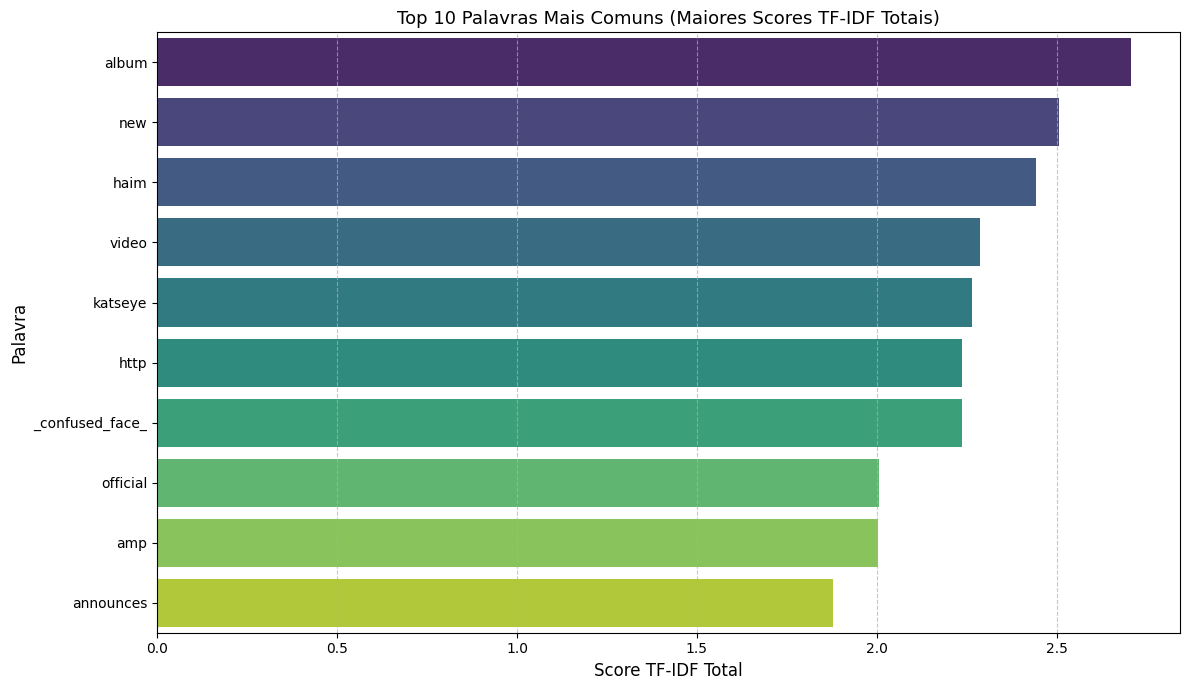

In [127]:
total_scores = tfidf_df.sum().sort_values(ascending=False)

num_top_words = 10
top_words_for_plot = total_scores.head(num_top_words)

plt.figure(figsize=(12, 7)) 
sns.barplot(x=top_words_for_plot.values, y=top_words_for_plot.index, palette='viridis')

plt.title(f'Top 10 Palavras Mais Comuns (Maiores Scores TF-IDF Totais)', fontsize=13)
plt.xlabel('Score TF-IDF Total', fontsize=12)
plt.ylabel('Palavra', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.show()

In [25]:
# c

### Modelagem de tópicos com NMF


In [27]:
from sklearn.decomposition import NMF

#### Aplicação do algoritmo

In [28]:
model = NMF(n_components=10, random_state=0)
model.fit(tfidf_matrix)

,n_components,10
,init,None
,solver,'cd'
,beta_loss,'frobenius'
,tol,0.0001
,max_iter,200
,random_state,0
,alpha_W,0.0
,alpha_H,'same'
,l1_ratio,0.0
,verbose,0


#### DataFrame com os tópicos e as palavras associadas

In [29]:
num_palavras = 10

dicionario_topicos = {}

for indice_topico, topico in enumerate(model.components_):
    
    chave_topico = f"Tópico {indice_topico}"
    
    feature_names = vectorizer.get_feature_names_out()
    dicionario_topicos[chave_topico] = [feature_names[i] for i in topico.argsort()[:-num_palavras - 1:-1]]

df_topicos = pd.DataFrame(dicionario_topicos)


In [30]:
df_topicos


,Tópico 0,Tópico 1,Tópico 2,Tópico 3,Tópico 4,Tópico 5,Tópico 6,Tópico 7,Tópico 8,Tópico 9
0,_confused_face_,gossip,new,benson,katseye,haim,leg,lorde,beach,alex
1,http,content,album,boone,gabriela,nan,mccall,hammer,caroline,warren
2,popheads,news,announces,american,nan,live,wet,nan,polachek,ordinary
3,com,allowed,night,heart,chaos,lounge,davina,pitchfork,stranding,week
4,www,banned,nan,review,highlight,wrong,video,track,nan,hot
5,reddit,removed,single,pitchfork,medley,addison,official,review,death,billboard
6,amp,link,maroon,theneedledrop,kid,rae,nan,charli,lyric,top
7,rate,post,friday,album,performs,rampage,twilight,remix,video,add
8,comment,music,tour,fun,gnarly,set,zone,xcx,moyka,third
9,th,tea,release,half,choice,headphone,hobert,year,deep,chart
